<a href="https://colab.research.google.com/github/GrizzlyToast/ML_Practise/blob/main/COMP551_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Acquire the Data

In [ ]:
!pip install unidecode
!pip install gensim

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/COMP551/data/WOS/WOS11967/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
from unidecode import unidecode
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import gensim
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')


ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

In [ ]:
MAX_LENGTH = 405

##Load WOS Dataset

This cell imports the textual data from the WOS dataset, parses it into words and creates meaningful word embeddings for the LSTM and BERT models to use.

In [ ]:
# Load WOS Dataset
def load_data(data_path):
    """
    Returns list of sentences for the input text and labels from files contained within data_path.
    """
    all_filenames = glob.glob(data_path + '*.txt')
    filepaths = {}
    for name in all_filenames:
        filepaths[name.split('/')[-1].split('.')[0]] = name

    with open(filepaths['X'], 'r') as f:
        text = [unidecode(line) for line in f.read().splitlines()]
    with open(filepaths['YL1'], 'r') as f:
        labels_l1 = [int(line) for line in f.read().splitlines()]
    with open(filepaths['YL2'], 'r') as f:
        labels_l2 = [int(line) for line in f.read().splitlines()]

    return text, labels_l1, labels_l2



def build_vocab(texts, max_vocab_size=10000):
    """
    Creates a vocabulary from a list of texts. It counts word frequencies, selects the most
    common words up to max_vocab_size, and assigns unique integer IDs to each word, including
    special tokens for padding (<PAD>) and unknown words (<UNK>).
    """
    word_counts = Counter()
    for text in texts:
        words = text.lower().split()
        word_counts.update(words) # create a list of tuples(word, frequency)

    most_common = word_counts.most_common(max_vocab_size - 2) # reduces the list of tuples( word, frequency) to the "max_vocab_size" most common words
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, (word, _) in enumerate(most_common):
        vocab[word] = i + 2 # creates a dictionary mapping the integer IDs to the most common words

    return vocab

def train_word2vec_on_corpus(texts, embedding_dim, window):
    """
    Trains a Word2Vec model (using the Skip-Gram algorithm) on the provided text corpus. It
    generates word embeddings, which are dense vector representations of words, based on
    their context.
    """
    # Creates an array of sentences, each sentence is a list of words
    sentences = [text.lower().split() for text in texts]

    # Uses Skip-Gram for geenrating word embeddings, can also set sg = 0 to use CBOW instead
    model = Word2Vec(
        sentences=sentences,
        vector_size=embedding_dim,
        window=window,
        min_count=0,
        workers=8,
        epochs=10,
        sg = 1
    )

    print(f"Trained Word2Vec with vocabulary of {len(model.wv)} words")
    return model.wv

def build_embedding_matrix(vocab, word2vec_wv, embedding_dim):
    """
    This function constructs an embedding matrix for the vocabulary. It populates this matrix
    with pre-trained Word2Vec embeddings for words found in the vocabulary and initializes
    out-of-vocabulary words with small random values. It also prints the percentage of
    successfully found word embeddings from Word2Vec
    """
    vocab_size = len(vocab)
    embedding_matrix = np.random.randn(vocab_size, embedding_dim) * 0.01

    # PAD token should be zeros
    embedding_matrix[0] = np.zeros(embedding_dim)

    # Copy word embeddings from Word2Vec into embedding matrix (words not found are left with random embedding)
    found = 0
    for word, idx in vocab.items():
        if word in word2vec_wv:
            embedding_matrix[idx] = word2vec_wv[word]
            found += 1

    coverage = 100 * found / vocab_size
    print(f"Embedding coverage:{coverage:.1f}%") #

    return embedding_matrix

def text_to_indices(text, vocab, max_len=405):
  """
  Converts a string of text into a list of indicies with a vocab ({word:int}) as reference. Furthermore,
  sequences are truncated to max_len in order to ensure all sequences haved a fixed length.
  """
    words = text.lower().split()[:max_len]

    # Fetches index of known or unkown word
    indices = [vocab.get(word, vocab['<UNK>']) for word in words]

    if len(indices) < max_len:
        indices += [vocab['<PAD>']] * (max_len - len(indices))

    return indices

##Defining the WOSDataset classes


In [ ]:
class WOSDataset(Dataset):
    """
    This class is a custom PyTorch Dataset for LSTM models. It prepares data samples,
    converting text to numerical indices and providing corresponding labels. It's designed
    to work with DataLoader for efficient batching.
    """
    def __init__(self, texts, labels, vocab, max_len=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = text_to_indices(text, self.vocab, self.max_len)
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

class WOSDatasetBERT(Dataset):
    """
    Similar to WOSDataset, but tailored for BERT models. It uses a BertTokenizer to
    tokenize and encode text, adding special tokens, padding, and attention masks required
    by BERT.
    """
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


#Defining the models

This section defines the model architectures for LSTM and BERT models, and also defines the helper functions required to train the models and fit the data.

##LSTM cell class

In [ ]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Forget gate
        self.W_f = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        # Input gate
        self.W_i = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        # Candidate gate
        self.W_c = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_o = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)

        f_t = torch.sigmoid(combined @ self.W_f.t() + self.b_f)
        i_t = torch.sigmoid(combined @ self.W_i.t() + self.b_i)
        c_tilde = torch.tanh(combined @ self.W_c.t() + self.b_c)
        c_t = f_t * c_prev + (i_t * c_tilde)
        o_t = torch.sigmoid(combined @ self.W_o.t() + self.b_o)
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


##LSTM model class

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, embedding_matrix=None, freeze_embeddings=False, num_layers=1, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.dropout_rate = dropout

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using:", self.device)


        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_matrix is not None:
            # Load pre-trained Word2Vec embeddings
            self.embedding.weight = nn.Parameter(torch.FloatTensor(embedding_matrix))
            print("Loaded Word2Vec embeddings: ", embedding_matrix.shape)

        # Freeze embeddings if desired
        self.embedding.weight.requires_grad = not freeze_embeddings
        if freeze_embeddings:
            print("Embeddings are frozen during training")


        self.lstm_cells = nn.ModuleList()

        # First layer
        self.lstm_cells.append(LSTMCell(embedding_dim, hidden_size))

        # Remaining layers
        for _ in range(1, num_layers):
            self.lstm_cells.append(LSTMCell(hidden_size, hidden_size))

        # Dropout between LSTM layers
        if num_layers > 1:
            self.dropout_layers = nn.ModuleList([nn.Dropout(dropout) for _ in range(num_layers - 1)])
        else:
            self.dropout_layers = nn.ModuleList()

        # Dropout before final classification layer
        self.fc_dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size()

        embedded = self.embedding(x)

        # Initialize hidden and cell states
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        # Process sequence
        for t in range(seq_len):
            x_t = embedded[:, t, :]

            for layer in range(self.num_layers):
                if layer == 0:
                    h[layer], c[layer] = self.lstm_cells[layer](x_t, h[layer], c[layer])
                else:
                    # Apply dropout to the output from the previous layer
                    h_input = self.dropout_layers[layer-1](h[layer-1]) if self.training else h[layer-1]
                    h[layer], c[layer] = self.lstm_cells[layer](h_input, h[layer], c[layer])

        # Apply dropout before final classification layer
        h_final = self.fc_dropout(h[-1])

        # Final classification
        output = self.fc(h_final)
        return output



    def fit(self, train_loader, val_loader=None, epochs=10, lr=0.001):

        self.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        train_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0

            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                # Forward pass
                outputs = self.forward(batch_x)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_loss)

            # Training
            train_acc = self.evaluate_acc(train_loader)
            train_accuracies.append(train_acc)

            # Validation
            val_acc = self.evaluate_acc(val_loader)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


        return train_losses, train_accuracies, val_accuracies

    def predict(self, data_loader):
        self.eval()
        predictions = []

        with torch.no_grad():
            for batch_x, _ in data_loader:
                batch_x = batch_x.to(self.device)
                outputs = self.forward(batch_x)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return np.array(predictions)

    def evaluate_acc(self, data_loader):
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_x, batch_y in data_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                outputs = self.forward(batch_x)
                _, predicted = torch.max(outputs, 1)

                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        accuracy = correct / total
        return accuracy


def train_lstm_model(X_train, y_train, X_val, y_val, vocab, word2vec_wv, num_classes,
                     embedding_dim, hidden_size=128, batch_size=128, epochs=10, lr = 0.001,
                     num_layers = 1, freeze_embeddings = True, dropout = 0.3):

    torch.manual_seed(11)
    np.random.seed(11)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(11)
        torch.cuda.manual_seed_all(11)


    # Build embedding matrix from Word2Vec
    embedding_matrix = build_embedding_matrix(vocab, word2vec_wv, embedding_dim)


    train_dataset = WOSDataset(X_train, y_train, vocab)
    val_dataset = WOSDataset(X_val, y_val, vocab)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel(
        vocab_size=len(vocab),
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_classes=num_classes,
        embedding_matrix=embedding_matrix,
        freeze_embeddings=freeze_embeddings,
        num_layers=num_layers,
        dropout=dropout
    )

    print(f"Training LSTM model")
    train_losses, train_accuracies, val_accuracies = model.fit(train_loader, val_loader, epochs=epochs, lr=lr)

    return model, train_losses, train_accuracies, val_accuracies


NameError: name 'nn' is not defined

##BERT Class

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes, dropout, epochs, learning_rate):
        super(BERTClassifier, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.epochs = epochs
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask, return_attention=False):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=return_attention
        )

        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.fc(output)

        if return_attention:
            return logits, outputs.attentions
        return logits


    def fit(self, train_loader, val_loader, epochs, lr):
        self.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(self.parameters(), lr)

        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        train_losses = []
        all_losses = []
        val_accuracies = []
        train_accuracies = []

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0


            for batch_idx, batch in enumerate(train_loader):

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.forward(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                epoch_loss += loss.item()

                all_losses.append(loss.item())

                if batch_idx % 50 == 0:
                    print(f"    Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

            avg_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_loss)

            val_acc = self.evaluate_acc(val_loader)
            val_accuracies.append(val_acc)

            train_acc = self.evaluate_acc(train_loader)
            train_accuracies.append(train_acc)

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return all_losses, train_losses, val_accuracies, train_accuracies

    def predict(self, data_loader):
        self.eval()
        predictions = []

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.forward(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return np.array(predictions)

    def evaluate_acc(self, data_loader):
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.forward(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

def train_bert_model(X_train, y_train, X_val, y_val, num_classes, batch_size, epochs, learning_rate, dropout):

    import gc

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("CUDA cache cleared")

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = WOSDatasetBERT(X_train, y_train, tokenizer)
    val_dataset = WOSDatasetBERT(X_val, y_val, tokenizer)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    model = BERTClassifier(num_classes=num_classes, dropout=dropout, epochs=epochs, learning_rate=learning_rate)

    print("Training BERT model")

    all_losses, train_losses, val_accuracies, train_accuracies = model.fit(train_loader, val_loader, epochs=epochs, lr=learning_rate)

    return model, train_loader, val_loader, tokenizer, all_losses, train_losses, val_accuracies, train_accuracies

In [ ]:
def evaluate_model(model, test_loader, model_type='LSTM'):
    if model_type == 'LSTM':
        y_true = []
        for _, labels in test_loader:
            y_true.extend(labels.numpy())
    else:
        y_true = []
        for batch in test_loader:
            y_true.extend(batch['labels'].numpy())

    y_pred = model.predict(test_loader)
    accuracy = accuracy_score(y_true, y_pred)

    return accuracy, y_true, y_pred

#Statistics on the dataset

In this section we look at how the length of the abstracts are distributed, in order to pick a reasonable length for the word embeddings such that less padding is necessary while still choosing a size that can fully containt most of the abstracts while only rejecting the outliers.

In [ ]:
#data cleaning to reduce size of letter vocabulary, unidecode to transform strings to ascii letters

all_filenames = glob.glob(data_path + '*.txt') #get all text files
#print(all_filenames)
filepaths = {}
for name in all_filenames:
  filepaths[name.split('/')[-1].split('.')[0]] = name

# define data and class labels
with open(filepaths['X'], 'r') as f:
    text = [unidecode(line) for line in f.read().splitlines()] #Notice decode to ascii in this line
with open(filepaths['YL1'], 'r') as f:
    labels_parent = [line.split('\n') for line in f.read().splitlines()]
with open(filepaths['YL2'], 'r') as f:
    labels_child = [line.split('\n') for line in f.read().splitlines()]

#This dataset should contain 11,967 documents
#print(len(text), len(labels_parent), len(labels_child))

Max length: 906, Min length: 22, Average length: 195.16921534219102, Standard deviation: 70.80644575931885, Median length: 189 


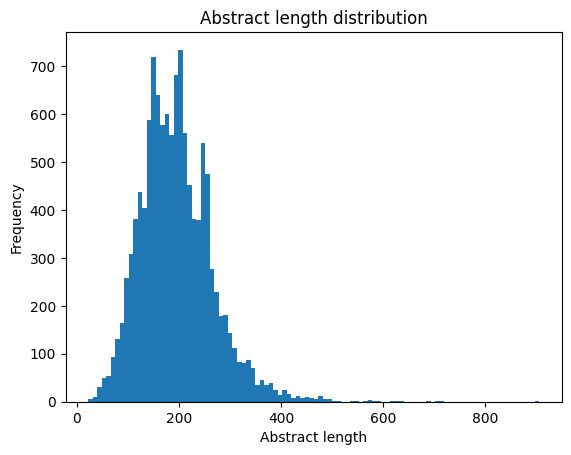

In [ ]:
import statistics
import matplotlib.pyplot as plt
abstracts = [abst.split() for abst in text]

max_length = max(len(abstract) for abstract in abstracts)
min_length = min(len(abstract) for abstract in abstracts)
average_length = sum(len(abstract) for abstract in abstracts) / len(abstracts)
median_length = statistics.median(len(abstract) for abstract in abstracts)
std_length = statistics.stdev(len(abstract) for abstract in abstracts)

print(f"Max length: {max_length}, Min length: {min_length}, Average length: {average_length}, Standard deviation: {std_length}, Median length: {median_length} ")

plt.hist([len(abstract) for abstract in abstracts], bins=100)
plt.xlabel('Abstract length')
plt.ylabel('Frequency')
plt.title('Abstract length distribution')
plt.show()

print(np.percentile(np.array([len(abstract) for abstract in abstracts]), 99)

In [ ]:
percentiles = [95, 99, 99.9, 99.99]
percentiles_values = [np.percentile(np.array([len(abstract) for abstract in abstracts]), percentile) for percentile in percentiles]
for i in range(4):
  print(f"{percentiles[i]}%: {percentiles_values[i]}")
#print(f"percentiles{(percentiles, percentiles_values) for i in range(4)}")

95%: 319.0
99%: 407.0
99.9%: 569.1020000000044
99.99%: 713.0339999999887


# Execution

In [ ]:
data_path = "WebOfScience/WOS11967/"

texts, labels_l1, labels_l2, merged_labels = load_data(data_path)
print(f"Loaded {len(texts)} documents")
print(f"YL1 classes: {len(set(labels_l1))}, YL2 classes: {len(set(labels_l2))}")
print(f"Merged Y classes: {len(set(merged_labels))}")


# Create word embeddings for all available data
sentences = [clean_text(t) for t in texts]
print("Number of sentences for embeddings:", len(sentences))


In [ ]:
# Train Word2Vec on corpus
print("Training Word2Vec on WOS corpus")
print("Uses skip-gram")
embedding_dim = 150
word2vec_wv = train_word2vec_on_corpus(sentences, embedding_dim=embedding_dim, window=6)



In [ ]:
X_train, X_temp, y_train_l1, y_temp_l1, y_train_l2, y_temp_l2, y_train_combo, y_temp_combo = train_test_split(
    sentences, labels_l1, labels_l2, merged_labels,
    test_size=0.3,
    random_state=11,
    stratify=labels_l1
)

X_val, X_test, y_val_l1, y_test_l1, y_val_l2, y_test_l2, y_val_combo, y_test_combo = train_test_split(
    X_temp, y_temp_l1, y_temp_l2, y_temp_combo,
    test_size=0.333,
    random_state=11,
    stratify=y_temp_l1
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(texts)*100:.1f}%)")
print(f"Val size: {len(X_val)} ({len(X_val)/len(texts)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(texts)*100:.1f}%)")

In [ ]:
from itertools import islice

print(f"Train: {len(X_train)}, Val: {len(X_val)}")


print("Building vocabulary:")
vocab = build_vocab(X_train)
print("Vocabulary size:", len(vocab))

# for key, value in islice(vocab.items(), 150):
#     print(f"Key: {key}, Value: {value}")

# LSTM Grid Search and Training


In [ ]:
import itertools
import pandas as pd

print("Grid Search for YL1")
# Define hyperparameter grid
param_grid = {
    'lr': [0.005, 0.009, 0.015],
    'num_layers': [1, 2, 3],
    'dropout': [0.2, 0.3, 0.5]
}

# Fixed parameters
fixed_params = {
    'embedding_dim': embedding_dim,
    'hidden_size': 256,
    'batch_size': 128,
    'epochs': 30,
    'freeze_embeddings': True,
    'num_classes': len(set(labels_l1))
}

# Storage for results
results = []

# Generate all combinations
param_combinations = list(itertools.product(
    param_grid['lr'],
    param_grid['num_layers'],
    param_grid['dropout']
))

total_experiments = len(param_combinations)

# Run grid search
for idx, (lr, num_layers, dropout) in enumerate(param_combinations, 1):
    print(f"Learning Rate: {lr}")
    print(f"Num Layers: {num_layers}")
    print(f"Dropout: {dropout}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()


    # Train model

    model, train_losses, train_accuracies, val_accuracies = train_lstm_model(
        X_train, y_train_l1, X_val, y_val_l1, vocab, word2vec_wv,
        num_classes=fixed_params['num_classes'],
        embedding_dim=fixed_params['embedding_dim'],
        hidden_size=fixed_params['hidden_size'],
        batch_size=fixed_params['batch_size'],
        epochs=fixed_params['epochs'],
        lr=lr,
        num_layers=num_layers,
        freeze_embeddings=fixed_params['freeze_embeddings'],
        dropout=dropout
    )


    # Get best validation accuracy and corresponding epoch
    best_val_acc = max(val_accuracies)
    best_epoch = val_accuracies.index(best_val_acc) + 1
    final_val_acc = val_accuracies[-1]
    final_train_acc = train_accuracies[-1]
    final_train_loss = train_losses[-1]

    # Store results
    result = {
        'experiment': idx,
        'lr': lr,
        'num_layers': num_layers,
        'dropout': dropout,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_acc': final_val_acc,
        'final_train_acc': final_train_acc,
        'final_train_loss': final_train_loss,
        'train_losses': train_losses.copy(),
        'train_accuracies': train_accuracies.copy(),
        'val_accuracies': val_accuracies.copy(),
        'model': model
    }

    results.append(result)

    print(f"Best Val Acc: {best_val_acc:.4f} (epoch {best_epoch})")
    print(f"Final Val Acc: {final_val_acc:.4f}")



# Create summary DataFrame
summary_df = pd.DataFrame([{
    'Experiment': r['experiment'],
    'LR': r['lr'],
    'Layers': r['num_layers'],
    'Dropout': r['dropout'],
    'Best Val Acc': r['best_val_acc'],
    'Best Epoch': r['best_epoch'],
    'Final Val Acc': r['final_val_acc'],
    'Final Train Acc': r['final_train_acc']
    } for r in results])


summary_df = summary_df.sort_values('Best Val Acc', ascending=False)


print(summary_df.to_string(index=False))

summary_df.to_csv('yl1_lstm_grid_search_summary.csv', index=False)

In [ ]:
print("LSTM ON YL1")

lstm_l1, train_losses, train_accuracies, val_accuracies = train_lstm_model(
    X_train, y_train_l1, X_val, y_val_l1, vocab, word2vec_wv,
    num_classes=len(set(labels_l1)),
    embedding_dim = embedding_dim,
    hidden_size = 256,
    batch_size = 128,
    epochs=30,
    lr = 0.009,
    num_layers = 2,
    freeze_embeddings = True,
    dropout=0.2
)

In [ ]:
test_dataset_lstm_l1 = WOSDataset(X_test, y_test_l1, vocab)
test_loader_lstm_l1 = DataLoader(test_dataset_lstm_l1, batch_size=128, shuffle=False)
lstm_l1_acc, _, _ = evaluate_model(lstm_l1, test_loader_lstm_l1, 'LSTM')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#1f77b4', marker='o')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].axhline(lstm_l1_acc, label=f'Test Accuracy: {lstm_l1_acc:.2f}', linestyle='--', linewidth=1, color='red')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add best validation accuracy annotation
best_val_epoch = np.argmax(val_accuracies)
best_val_acc = val_accuracies[best_val_epoch]

plt.tight_layout()
plt.savefig('yl1_lstm.svg')
plt.show()

In [ ]:
import itertools
import pandas as pd

print("Grid Search for YL2")
# Define hyperparameter grid
param_grid = {
    'lr': [0.005, 0.009, 0.015],
    'num_layers': [1, 2, 3],
    'dropout': [0.2, 0.3, 0.5]
}

# Fixed parameters
fixed_params = {
    'embedding_dim': embedding_dim,
    'hidden_size': 256,
    'batch_size': 128,
    'epochs': 30,
    'freeze_embeddings': True,
    'num_classes': len(set(labels_l2))
}

# Storage for results
results = []

# Generate all combinations
param_combinations = list(itertools.product(
    param_grid['lr'],
    param_grid['num_layers'],
    param_grid['dropout']
))

total_experiments = len(param_combinations)

# Run grid search
for idx, (lr, num_layers, dropout) in enumerate(param_combinations, 1):
    print(f"Learning Rate: {lr}")
    print(f"Num Layers: {num_layers}")
    print(f"Dropout: {dropout}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()


    # Train model

    model, train_losses, train_accuracies, val_accuracies = train_lstm_model(
        X_train, y_train_l2, X_val, y_val_l2, vocab, word2vec_wv,
        num_classes=fixed_params['num_classes'],
        embedding_dim=fixed_params['embedding_dim'],
        hidden_size=fixed_params['hidden_size'],
        batch_size=fixed_params['batch_size'],
        epochs=fixed_params['epochs'],
        lr=lr,
        num_layers=num_layers,
        freeze_embeddings=fixed_params['freeze_embeddings'],
        dropout=dropout
    )


    # Get best validation accuracy and corresponding epoch
    best_val_acc = max(val_accuracies)
    best_epoch = val_accuracies.index(best_val_acc) + 1
    final_val_acc = val_accuracies[-1]
    final_train_acc = train_accuracies[-1]
    final_train_loss = train_losses[-1]

    # Store results
    result = {
        'experiment': idx,
        'lr': lr,
        'num_layers': num_layers,
        'dropout': dropout,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_acc': final_val_acc,
        'final_train_acc': final_train_acc,
        'final_train_loss': final_train_loss,
        'train_losses': train_losses.copy(),
        'train_accuracies': train_accuracies.copy(),
        'val_accuracies': val_accuracies.copy(),
        'model': model
    }

    results.append(result)

    print(f"Best Val Acc: {best_val_acc:.4f} (epoch {best_epoch})")
    print(f"Final Val Acc: {final_val_acc:.4f}")



# Create summary DataFrame
summary_df = pd.DataFrame([{
    'Experiment': r['experiment'],
    'LR': r['lr'],
    'Layers': r['num_layers'],
    'Dropout': r['dropout'],
    'Best Val Acc': r['best_val_acc'],
    'Best Epoch': r['best_epoch'],
    'Final Val Acc': r['final_val_acc'],
    'Final Train Acc': r['final_train_acc']
    } for r in results])


summary_df = summary_df.sort_values('Best Val Acc', ascending=False)


print(summary_df.to_string(index=False))

summary_df.to_csv('yl2_lstm_grid_search_summary.csv', index=False)

In [ ]:
print("LSTM ON YL2")

lstm_l2, train_losses, train_accuracies, val_accuracies = train_lstm_model(
    X_train, y_train_l2, X_val, y_val_l2, vocab, word2vec_wv,
    num_classes=len(set(labels_l2)),
    embedding_dim = embedding_dim,
    hidden_size = 256,
    batch_size = 128,
    epochs=30,
    lr = 0.009,
    num_layers = 2,
    freeze_embeddings = True,
    dropout=0.2
)

In [ ]:
test_dataset_lstm_l2 = WOSDataset(X_test, y_test_l2, vocab)
test_loader_lstm_l2 = DataLoader(test_dataset_lstm_l2, batch_size=32, shuffle=False)
lstm_l2_acc, _, _ = evaluate_model(lstm_l2, test_loader_lstm_l2, 'LSTM')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#1f77b4', marker='o')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].axhline(lstm_l2_acc, label=f'Test Accuracy: {lstm_l2_acc:.2f}', linestyle='--', linewidth=1, color='red')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add best validation accuracy annotation
best_val_epoch = np.argmax(val_accuracies)
best_val_acc = val_accuracies[best_val_epoch]

plt.tight_layout()
plt.savefig('yl2_lstm.svg')
plt.show()

In [ ]:
print("LSTM ON Y COMBINED")

lstm_lc, train_losses, train_accuracies, val_accuracies = train_lstm_model(
    X_train, y_train_combo, X_val, y_val_combo, vocab, word2vec_wv,
    num_classes=len(set(merged_labels)),
    embedding_dim = embedding_dim,
    hidden_size = 256,
    batch_size = 128,
    epochs=30,
    lr = 0.009,
    num_layers = 2,
    freeze_embeddings = True,
    dropout=0.2
)

In [ ]:
test_dataset_lstm_combo= WOSDataset(X_test, y_test_combo, vocab)
test_loader_lstm_combo = DataLoader(test_dataset_lstm_combo, batch_size=32, shuffle=False)
lstm_lc_acc, _, _ = evaluate_model(lstm_lc, test_loader_lstm_combo, 'LSTM')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#1f77b4', marker='o')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].axhline(lstm_lc_acc, label=f'Test Accuracy: {lstm_lc_acc:.2f}', linestyle='--', linewidth=1, color='red')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

best_val_epoch = np.argmax(val_accuracies)
best_val_acc = val_accuracies[best_val_epoch]

plt.tight_layout()
plt.savefig('y_combo_lstm.svg')
plt.show()

# BERT Grid Search and Training

In [ ]:
import gc
import itertools

print("Grid Search for BERT parameters")

param_grid = {
    'learning_rate': [2e-5, 5e-5],
    'dropout': [0.1, 0.3, 0.5]
}

param_combinations = list(itertools.product(
    param_grid['learning_rate'],
    param_grid['dropout']
))


results_data = []

for i, (lr, dropout) in enumerate(param_combinations, 1):
    print(f"Learning rate: {lr}, Dropout: {dropout}")

    # Clean up memory
    try:
        del bert_model, train_loader, val_loader, tokenizer
        del all_losses, train_losses, val_accuracies, train_accuracies
    except:
        pass

    gc.collect()
    torch.cuda.empty_cache()

    bert_model, train_loader, val_loader, tokenizer, all_losses, train_losses, val_accuracies, train_accuracies = train_bert_model(
        X_train, y_train_l1, X_val, y_val_l1,
        num_classes=len(set(labels_l1)),
        batch_size=16,
        epochs=5,
        learning_rate=lr,
        dropout=dropout
    )

    # Store results for each epoch
    for epoch in range(len(train_accuracies)):
        results_data.append({
            'experiment': i,
            'learning_rate': lr,
            'dropout': dropout,
            'epoch': epoch + 1,
            'train_accuracy': train_accuracies[epoch],
            'val_accuracy': val_accuracies[epoch]
        })


df_results = pd.DataFrame(results_data)

df_results = df_results.sort_values('val_accuracy', ascending=False)

df_results.to_csv('bert_grid_search_results.csv', index=False)




In [ ]:
# Delete any existing models/variables
try:
    del bert_l1, train_loader, val_loader, tokenizer
    del all_losses, train_losses, val_accuracies, train_accuracies
except:
    pass

# Force garbage collection
import gc
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

# Now train
print("BERT ON YL1")
bert_l1, train_loader, val_loader, tokenizer, all_losses, train_losses, val_accuracies, train_accuracies = train_bert_model(
    X_train, y_train_l1, X_val, y_val_l1,
    num_classes=len(set(labels_l1)),
    batch_size=16,
    epochs=5,
    learning_rate=5e-5,
    dropout=0.1
)
import pickle

filename = 'bert_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(bert_l1, file)

In [ ]:
test_dataset_bert_l1= WOSDatasetBERT(X_test, y_test_l1, tokenizer)
test_loader_bert_l1 = DataLoader(test_dataset_bert_l1, batch_size=16, shuffle=False)
lstm_lc_acc, _, _ = evaluate_model(bert_l1, test_loader_bert_l1, 'BERT')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#1f77b4', marker='o')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].axhline(lstm_lc_acc, label=f'Test Accuracy: {lstm_lc_acc:.2f}', linestyle='--', linewidth=1, color='red')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

best_val_epoch = np.argmax(val_accuracies)
best_val_acc = val_accuracies[best_val_epoch]

plt.tight_layout()
plt.savefig('y_l1_bert.svg')
plt.show()

In [ ]:
print("BERT ON YL2")
bert_l2, train_loader, val_loader, tokenizer, all_losses, train_losses, val_accuracies, train_accuracies = train_bert_model(
    X_train, y_train_l2, X_val, y_val_l2,
    num_classes=len(set(labels_l2)),
    batch_size=16,
    epochs=5,
    learning_rate=5e-5,
    dropout=0.1
)

In [ ]:
test_dataset_bert_l2= WOSDatasetBERT(X_test, y_test_l2, tokenizer)
test_loader_bert_l2 = DataLoader(test_dataset_bert_l2, batch_size=16, shuffle=False)
bert_acc, _, _ = evaluate_model(bert_l2, test_loader_bert_l2, 'BERT')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#1f77b4', marker='o')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].axhline(bert_acc, label=f'Test Accuracy: {bert_acc:.2f}', linestyle='--', linewidth=1, color='red')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

best_val_epoch = np.argmax(val_accuracies)
best_val_acc = val_accuracies[best_val_epoch]

plt.tight_layout()
plt.savefig('y_l2_bert.svg')
plt.show()

In [ ]:
print("BERT ON Y COMBINED")
bert_lcombo, train_loader, val_loader, tokenizer, all_losses, train_losses, val_accuracies, train_accuracies = train_bert_model(
    X_train, y_train_combo, X_val, y_val_combo,
    num_classes=len(set(merged_labels)),
    batch_size=16,
    epochs=5,
    learning_rate=5e-5,
    dropout=0.1
)

In [ ]:
test_dataset_bert_lcombo= WOSDatasetBERT(X_test, y_test_combo, tokenizer)
test_loader_bert_lcombo = DataLoader(test_dataset_bert_lcombo, batch_size=16, shuffle=False)
lstm_lc_acc, _, _ = evaluate_model(bert_lcombo, test_loader_bert_lcombo, 'BERT')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#1f77b4', marker='o')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].axhline(lstm_lc_acc, label=f'Test Accuracy: {lstm_lc_acc:.2f}', linestyle='--', linewidth=1, color='red')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

best_val_epoch = np.argmax(val_accuracies)
best_val_acc = val_accuracies[best_val_epoch]

plt.tight_layout()
plt.savefig('y_combo_bert.svg')
plt.show()

# Visualising BERT Attention Matrices

In [ ]:
# Attention Visualization

stopwords = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
    'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'be',
    'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will',
    'would', 'should', 'could', 'may', 'might', 'must', 'can', 'this',
    'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they',
    'my', 'your', 'his', 'her', 'its', 'our', 'their', 'me', 'him', 'them',
    'us', 'what', 'which', 'who', 'when', 'where', 'why', 'how'
}

label_names = {
    0: 'Computer Science',
    1: 'Electrical Engineering',
    2: 'Psychology',
    3: 'Mechanical Engineering',
    4: 'Civil Engineering',
    5: 'Medical Science',
    6: 'Biochemistry'
}


def analyze_attention_patterns(model, test_loader, tokenizer, num_samples=3):
    model.eval()
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            for i in range(len(predictions)):

                text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                true_label = labels[i].item()
                pred_label = predictions[i].item()

                if pred_label == true_label and len(correct_samples) < num_samples:
                    correct_samples.append((text, true_label, pred_label))
                elif pred_label != true_label and len(incorrect_samples) < num_samples:
                    incorrect_samples.append((text, true_label, pred_label))

                if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                    return correct_samples, incorrect_samples

    return correct_samples, incorrect_samples

def get_aggregate_attention(model, text, tokenizer):
    model.eval()

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    with torch.no_grad():
        _, attentions = model.forward(input_ids, attention_mask, return_attention=True)

    all_attentions = torch.stack([att for att in attentions])
    all_attentions = all_attentions.squeeze(1)

    aggregate = all_attentions.mean(dim=[0, 1])

    return aggregate.cpu().numpy(), encoding

def visualize_attention_heatmap(model, text, label, tokenizer, prediction, ):
    aggregate_attention, encoding = get_aggregate_attention(model, text, tokenizer)

    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0].cpu().numpy())
    attention_mask = encoding['attention_mask'][0]
    valid_length = attention_mask.sum().item()

    tokens = tokens[:valid_length]
    attention = aggregate_attention[:valid_length, :valid_length]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(attention, cmap='viridis')

    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)

    plt.colorbar(im, ax=ax)
    plt.title(f'Average Attention Matrix \nTrue: {label_names[label]}, Predicted: {label_names[prediction]}')
    plt.tight_layout()

    return fig


def visualize_content_words(model, text, label, tokenizer, prediction, layer_idx=11, top_n=15):
    model.eval()

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    with torch.no_grad():
        _, attentions = model.forward(input_ids, attention_mask, return_attention=True)

    attention = attentions[layer_idx][0].mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    valid_length = attention_mask[0].sum().item()
    tokens = tokens[:valid_length]
    attention = attention[:valid_length, :valid_length]

    attention_received = attention.sum(axis=0)

    content_tokens = []
    content_attention = []

    for token, score in zip(tokens, attention_received):
        clean_token = token.replace('##', '').lower()
        if token not in ['[CLS]', '[SEP]', '[PAD]'] and clean_token not in stopwords:
            content_tokens.append(token)
            content_attention.append(score)

    if not content_tokens:
        return None

    sorted_idx = np.argsort(content_attention)[::-1][:top_n]
    top_tokens = [content_tokens[i] for i in sorted_idx]
    top_attention = [content_attention[i] for i in sorted_idx]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(range(len(top_tokens)), top_attention)
    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels(top_tokens)
    ax.set_xlabel('Attention Score')
    ax.set_title(f'Top {top_n} Content Words\nTrue: {label_names[label]}, Predicted: {label_names[prediction]}')
    ax.invert_yaxis()

    plt.tight_layout()

    return fig

In [ ]:
import pickle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


test_dataset_bert_l1 = WOSDatasetBERT(X_val, y_val_l1, tokenizer)
test_loader_bert_l1 = DataLoader(test_dataset_bert_l1, batch_size=32, shuffle=True)

with open('bert_model.pkl', 'rb') as file:
    bert_l1 = pickle.load(file)

correct_samples, incorrect_samples = analyze_attention_patterns(bert_l1, test_loader_bert_l1, tokenizer, num_samples=3)

# Correct predictions
print("Correct Predictions")

for i, (text, true_label, pred_label) in enumerate(correct_samples):

    fig = visualize_attention_heatmap(bert_l1, text, true_label, tokenizer, pred_label)
    # plt.savefig(f"correct_attention_bert_{i}.svg")
    plt.show()

    fig = visualize_content_words(bert_l1, text, true_label, tokenizer, pred_label, top_n=15)
    # plt.savefig(f"correct_words_bert_{i}.svg")

    plt.show()

print("Incorrect Predictions")
for i, (text, true_label, pred_label) in enumerate(incorrect_samples):

    fig = visualize_attention_heatmap(bert_l1, text, true_label, tokenizer, pred_label)
    # plt.savefig(f"incorrect_attention_bert_{i}.svg")
    plt.show()

    fig = visualize_content_words(bert_l1, text, true_label, tokenizer, pred_label, top_n=15)
    # plt.savefig(f"incorrect_words_bert_{i}.svg")
    plt.show()

# Extension: Compare Word2Vec Initialisation and Random Initialisation

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader



# Compare Word2Vec initialization vs random initialization


print("Word2Vec vs Random Initialization")

train_dataset = WOSDataset(X_train, y_train_l1, vocab)
val_dataset = WOSDataset(X_val, y_val_l1, vocab)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Model with Word2Vec
print("Training with Word2Vec embeddings")
embedding_matrix = build_embedding_matrix(vocab, word2vec_wv, 150)
model_w2v = LSTMModel(
    vocab_size=len(vocab),
    embedding_dim=150,
    hidden_size=128,
    num_classes=len(set(labels_l1)),
    embedding_matrix=embedding_matrix,
    freeze_embeddings=True,
    num_layers=2,
    dropout=0.2
)

train_losses_w2v, train_accuracies_w2v, val_accuracies_w2v = model_w2v.fit(train_loader,
                                                                           val_loader,
                                                                           epochs=30,
                                                                           lr=0.009
                                                                           )
final_acc_w2v = model_w2v.evaluate_acc(val_loader)

# Model with random initialization
print("Training with random initialization")
model_random = LSTMModel(
    vocab_size=len(vocab),
    embedding_dim=150,
    hidden_size=128,
    num_classes=len(set(labels_l1)),
    embedding_matrix=None, # Random Initialisation
    freeze_embeddings=False
)

train_losses_random , train_accuracies_random , val_accuracies_random = model_random.fit(train_loader,
                                                                                         val_loader,
                                                                                         epochs=30,
                                                                                         lr=0.009
                                                                                         )
final_acc_random = model_random.evaluate_acc(val_loader)


print("Word2Vec initialization:", final_acc_w2v)
print("Random initialization:", final_acc_random)




In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [1, 1.5, 0.8]})

# Plot 1: Training Loss Comparison
axes[0].plot(train_losses_w2v, label='Word2Vec Initialization', linewidth=2, color='#1f77b4')
axes[0].plot(train_losses_random, label='Random Initialization', linewidth=2, color='#ff7f0e')
axes[0].set_title('Training Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies_w2v, label='Train: Word2Vec', linestyle='-', linewidth=2, color='#1f77b4')
axes[1].plot(val_accuracies_w2v, label='Validation: Word2Vec', linestyle='--', linewidth=2, color='#1f77b4')
axes[1].plot(train_accuracies_random, label='Train: Random', linestyle='-', linewidth=2, color='#ff7f0e')
axes[1].plot(val_accuracies_random, label='Validation: Random', linestyle='--', linewidth=2, color='#ff7f0e')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Final Validation Accuracy Comparison (Bar chart)
methods = ['Word2Vec\nInitialisation', 'Random\nInitilisation']
final_accs = [final_acc_w2v, final_acc_random]
colors_bar = ['#1f77b4', '#ff7f0e']

bars = axes[2].bar(methods, final_accs, color=colors_bar, width=0.5)
axes[2].set_title('Final Validation Accuracy')
axes[2].set_ylabel('Accuracy')
axes[2].set_ylim([min(final_accs) - 0.15, max(final_accs) + 0.05])

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, final_accs)):
    axes[2].text(bar.get_x() + bar.get_width()/2, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("word2vec_vs_random_initialisation.svg", bbox_inches='tight')
plt.show()

# Extension: Embedding Dimension

In [ ]:
print("Embedding Dimension")

dimensions = [50, 100, 150, 200, 250, 300]
results = []

for dim in dimensions:
    print("Testing embedding dimension:", dim)

    data_path = "WebOfScience/WOS11967/"

    texts, labels_l1, labels_l2, merged_labels = load_data(data_path)
    print(f"Loaded {len(texts)} documents")
    print(f"YL1 classes: {len(set(labels_l1))}, YL2 classes: {len(set(labels_l2))}")
    print(f"Merged Y classes: {len(set(merged_labels))}")

    texts = [clean_text(t) for t in texts]
    sentences = [text.lower().split() for text in texts]


    w2v_model = Word2Vec(sentences=sentences, vector_size=dim, window=6, min_count=0, workers=8, epochs=10, sg=1)

    embedding_matrix = build_embedding_matrix(vocab, w2v_model.wv, dim)

    train_dataset = WOSDataset(X_train, y_train_l1, vocab)
    val_dataset = WOSDataset(X_val, y_val_l1, vocab)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    model = LSTMModel(
        vocab_size=len(vocab),
        embedding_dim=dim,
        hidden_size=128,
        num_classes=len(set(labels_l1)),
        embedding_matrix=embedding_matrix,
        freeze_embeddings=True,
        num_layers=2,
        dropout=0.2
    )

    train_losses, train_accs, val_accs = model.fit(train_loader, val_loader, epochs=30, lr=0.009)
    best_val_acc = np.max(val_accs)
    final_val_acc = val_accs[-1]
    n_params = sum(p.numel() for p in model.parameters())

    results.append({
        'Dimension': dim,
        'Accuracy': best_val_acc,
        'Parameters': n_params
    })

    print(f"Accuracy:", best_val_acc)

df = pd.DataFrame(results)



In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df['Dimension'], df['Accuracy'], 'b-o', linewidth=2)
ax1.set_xlabel('Embedding Dimension')
ax1.set_ylabel('Validation Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(df['Dimension'], df['Parameters'], 'r--s', linewidth=2)
ax2.set_ylabel('Number of Parameters', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Effect of Embedding Dimension on LSTM Performance')
plt.tight_layout()
plt.savefig('embedding_dim_effect.svg')
plt.show()

# Extension: Input Sequence Length

In [ ]:
import time

print("Input Sequence Length Analysis")

sequence_lengths = [50, 100, 150, 200, 250, 300, 350]
results = []

data_path = "WebOfScience/WOS11967/"

texts, labels_l1, labels_l2, merged_labels = load_data(data_path)
print(f"Loaded {len(texts)} documents")
print(f"YL1 classes: {len(set(labels_l1))}, YL2 classes: {len(set(labels_l2))}")
print(f"Merged Y classes: {len(set(merged_labels))}")

sentences = [text.lower().split() for text in X_train]


print("Training Word2Vec model")
w2v_model = Word2Vec(sentences=sentences, vector_size=150, window=5, min_count=2, workers=4, epochs=10, sg=1)
embedding_matrix = build_embedding_matrix(vocab, w2v_model.wv, 150)

for seq_len in sequence_lengths:
    print("Testing sequence_length: ", seq_len)

    train_dataset = WOSDataset(X_train, y_train_l1, vocab, max_len=seq_len)
    val_dataset = WOSDataset(X_val, y_val_l1, vocab, max_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    model = LSTMModel(
        vocab_size=len(vocab),
        embedding_dim=150,
        hidden_size=128,
        num_classes=len(set(labels_l1)),
        embedding_matrix=embedding_matrix,
        freeze_embeddings=True,
        num_layers=2,
        dropout=0.2
    )

    start_time = time.time()
    train_losses, train_accs, val_accs = model.fit(train_loader,
                                                   val_loader,
                                                   epochs=30,
                                                   lr=0.009)
    training_time = time.time() - start_time

    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]
    best_val_acc = np.max(val_accs)
    n_params = sum(p.numel() for p in model.parameters())

    # Calculate average text length coverage
    text_lengths = [len(text.lower().split()) for text in X_train]
    coverage = sum(1 for length in text_lengths if length <= seq_len) / len(text_lengths) * 100

    results.append({
        'Sequence Length': seq_len,
        'Train Accuracy': final_train_acc,
        'Val Accuracy': final_val_acc,
        'Best Val Accuracy': best_val_acc,
        'Parameters': n_params,
        'Text Coverage': coverage,
        'Training Time': training_time/60
    })



df_seq_len = pd.DataFrame(results)
df_seq_len.to_csv("df_seq_len.csv", index=False)



In [ ]:
print(df_seq_len.to_string(index=False))


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs Sequence Length
axes[0].plot(df_seq_len['Sequence Length'], df_seq_len['Train Accuracy'],
                marker='o', linewidth=2, label='Train Accuracy', color='#1f77b4')
axes[0].plot(df_seq_len['Sequence Length'], df_seq_len['Val Accuracy'],
                marker='s', linewidth=2, label='Validation Accuracy', color='#ff7f0e')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Effect of Sequence Length on LSTM Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

text_lengths = [len(text.lower().split()) for text in X_train]

axes[1].hist(text_lengths, bins=50, alpha=0.7, color='#1f77b4', edgecolor='black')
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', "#1533b9",  "#c81cce"]

for i, seq_len in enumerate(sequence_lengths):
    axes[1].axvline(x=seq_len, color=colors[i], linestyle='--', linewidth=2,
                label=f'Sequence Length: {seq_len}')

axes[1].set_xlabel('Text Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Text Lengths in Training Set')
axes[1].legend()

plt.tight_layout()
plt.savefig("sequence_length_analysis.svg", bbox_inches='tight')
plt.show()

percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(text_lengths, p)
    print(f"  {p}th percentile: {val:.0f} words")